Importando as bibliotecas

In [54]:
import os
import requests
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

Importando os dados

In [2]:
diretorio_principal = os.getcwd()
subdiretorio_dados = os.path.join(diretorio_principal, "Dados")

# Criar o diretório se não existir
os.makedirs(subdiretorio_dados, exist_ok=True)

In [3]:
anos = range(2008, 2024)
formato = "csv"
url_base = "http://www.camara.leg.br/cotas/"

for ano in anos:
    download = requests.get(url_base + f"Ano-{ano}.{formato}.zip")
    caminho_zip = os.path.join(subdiretorio_dados, f"Ano-{ano}.{formato}.zip")

    with open(caminho_zip, "wb") as file:
        file.write(download.content)

    # Extrair o conteúdo do arquivo ZIP
    with zipfile.ZipFile(caminho_zip, 'r') as zip_ref:
        zip_ref.extractall(subdiretorio_dados)

    # # Remover o arquivo ZIP após extração (opcional)
    # os.remove(caminho_zip)

In [4]:
# Voltar ao diretório principal
os.chdir(diretorio_principal)

# Criar um DataFrame com os dados extraídos
despesas_totais = []

for arquivo_csv in os.listdir(subdiretorio_dados):
    if arquivo_csv.endswith('.csv') and not arquivo_csv.startswith("."):
        caminho_csv = os.path.join(subdiretorio_dados, arquivo_csv)
        despesas = pd.read_csv(caminho_csv, sep=";", encoding='UTF-8', low_memory=False)
        despesas_totais.append(despesas)

# Concatenar todos os DataFrames em um único DataFrame
despesas_completo = pd.concat(despesas_totais, ignore_index=True)

In [5]:
despesas_completo

,txNomeParlamentar,cpf,ideCadastro,nuCarteiraParlamentar,nuLegislatura,sgUF,sgPartido,codLegislatura,numSubCota,txtDescricao,...,numParcela,txtPassageiro,txtTrecho,numLote,numRessarcimento,datPagamentoRestituicao,vlrRestituicao,nuDeputadoId,ideDocumento,urlDocumento
0,JOSEPH BANDEIRA,7.251603e+09,4929.0,565.0,2007,BA,PT,53,2,"LOCOMOÇÃO, ALIMENTAÇÃO E HOSPEDAGEM",...,0,NaN,NaN,405260,NaN,NaN,NaN,1970,1612380,NaN
1,JOSEPH BANDEIRA,7.251603e+09,4929.0,565.0,2007,BA,PT,53,2,"LOCOMOÇÃO, ALIMENTAÇÃO E HOSPEDAGEM",...,0,NaN,NaN,387830,NaN,NaN,NaN,1970,1561354,NaN
2,SILVIO COSTA,1.048139e+10,4930.0,160.0,2007,PE,PTB,53,10,TELEFONIA,...,0,NaN,NaN,0,0.0,NaN,NaN,1973,0,NaN
3,ALDO REBELO,1.641215e+10,73428.0,331.0,2007,SP,PCdoB,53,10,TELEFONIA,...,0,NaN,NaN,0,0.0,NaN,NaN,764,0,NaN
4,ANTONIO CARLOS PANNUNZIO,1.895236e+10,73431.0,334.0,2007,SP,PSDB,53,10,TELEFONIA,...,0,NaN,NaN,0,0.0,NaN,NaN,961,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4666836,Dr Fabio Rueda,2.539052e+09,227401.0,569.0,2023,AC,UNIÃO,57,998,PASSAGEM AÉREA - SIGEPA,...,0,FABIO GONCALVES DE RUEDA,BSB/GRU/REC,0,0.0,NaN,NaN,3755,218349,NaN
4666837,Douglas Viegas,2.551906e+10,227433.0,571.0,2023,SP,UNIÃO,57,5,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,...,0,NaN,NaN,2002507,NaN,NaN,NaN,3756,7669098,https://www.camara.leg.br/cota-parlamentar/doc...
4666838,Douglas Viegas,2.551906e+10,227433.0,571.0,2023,SP,UNIÃO,57,10,TELEFONIA,...,0,NaN,NaN,0,0.0,NaN,NaN,3756,0,NaN
4666839,Douglas Viegas,2.551906e+10,227433.0,571.0,2023,SP,UNIÃO,57,120,LOCAÇÃO OU FRETAMENTO DE VEÍCULOS AUTOMOTORES,...,0,NaN,NaN,2003390,NaN,NaN,NaN,3756,7670764,https://www.camara.leg.br/cota-parlamentar/doc...


Selecionando colunas de interesse

In [6]:
# Listar colunas
despesas_completo.columns

Index(['txNomeParlamentar', 'cpf', 'ideCadastro', 'nuCarteiraParlamentar',
       'nuLegislatura', 'sgUF', 'sgPartido', 'codLegislatura', 'numSubCota',
       'txtDescricao', 'numEspecificacaoSubCota', 'txtDescricaoEspecificacao',
       'txtFornecedor', 'txtCNPJCPF', 'txtNumero', 'indTipoDocumento',
       'datEmissao', 'vlrDocumento', 'vlrGlosa', 'vlrLiquido', 'numMes',
       'numAno', 'numParcela', 'txtPassageiro', 'txtTrecho', 'numLote',
       'numRessarcimento', 'datPagamentoRestituicao', 'vlrRestituicao',
       'nuDeputadoId', 'ideDocumento', 'urlDocumento'],
      dtype='object')

In [7]:
# Selecionar colunas
dataset = despesas_completo.loc[:,['sgUF', 'sgPartido', 'txtDescricao', 'datEmissao', 'vlrLiquido']]

In [8]:
# Visualizar dados de estudo
dataset

,sgUF,sgPartido,txtDescricao,datEmissao,vlrLiquido
0,BA,PT,"LOCOMOÇÃO, ALIMENTAÇÃO E HOSPEDAGEM",2009-06-18T00:00:00,3800.00
1,BA,PT,"LOCOMOÇÃO, ALIMENTAÇÃO E HOSPEDAGEM",2009-03-30T00:00:00,6000.00
2,PE,PTB,TELEFONIA,2008-12-01T00:00:00,80.01
3,SP,PCdoB,TELEFONIA,2008-12-01T00:00:00,372.55
4,SP,PSDB,TELEFONIA,2008-03-10T00:00:00,38.48
...,...,...,...,...,...
4666836,AC,UNIÃO,PASSAGEM AÉREA - SIGEPA,2023-12-20T12:00:00,1367.51
4666837,SP,UNIÃO,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2023-12-28T00:00:00,11000.00
4666838,SP,UNIÃO,TELEFONIA,NaN,0.51
4666839,SP,UNIÃO,LOCAÇÃO OU FRETAMENTO DE VEÍCULOS AUTOMOTORES,2023-12-28T00:00:00,1393.34


Conferindo dados Selecionados

In [9]:
dataset.head(10)

,sgUF,sgPartido,txtDescricao,datEmissao,vlrLiquido
0,BA,PT,"LOCOMOÇÃO, ALIMENTAÇÃO E HOSPEDAGEM",2009-06-18T00:00:00,3800.00
1,BA,PT,"LOCOMOÇÃO, ALIMENTAÇÃO E HOSPEDAGEM",2009-03-30T00:00:00,6000.00
2,PE,PTB,TELEFONIA,2008-12-01T00:00:00,80.01
3,SP,PCdoB,TELEFONIA,2008-12-01T00:00:00,372.55
4,SP,PSDB,TELEFONIA,2008-03-10T00:00:00,38.48
5,SP,PSDB,TELEFONIA,2008-12-01T00:00:00,15.21
6,SP,PTB,TELEFONIA,2008-12-01T00:00:00,31.57
7,SP,PP**,COMBUSTÍVEIS E LUBRIFICANTES.,2008-11-03T00:00:00,156.01
8,SP,PP**,COMBUSTÍVEIS E LUBRIFICANTES.,2008-11-28T00:00:00,151.00
9,SP,PP**,COMBUSTÍVEIS E LUBRIFICANTES.,2008-12-09T00:00:00,39.00


In [10]:
dataset.tail(10)

,sgUF,sgPartido,txtDescricao,datEmissao,vlrLiquido
4666831,AC,UNIÃO,COMBUSTÍVEIS E LUBRIFICANTES.,2023-12-20T00:00:00,265.03
4666832,AC,UNIÃO,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2023-12-28T00:00:00,12500.00
4666833,AC,UNIÃO,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2023-12-20T00:00:00,10000.00
4666834,AC,UNIÃO,PASSAGEM AÉREA - REEMBOLSO,2023-12-16T00:00:00,1525.25
4666835,AC,UNIÃO,TELEFONIA,NaN,1.44
4666836,AC,UNIÃO,PASSAGEM AÉREA - SIGEPA,2023-12-20T12:00:00,1367.51
4666837,SP,UNIÃO,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,2023-12-28T00:00:00,11000.00
4666838,SP,UNIÃO,TELEFONIA,NaN,0.51
4666839,SP,UNIÃO,LOCAÇÃO OU FRETAMENTO DE VEÍCULOS AUTOMOTORES,2023-12-28T00:00:00,1393.34
4666840,SP,UNIÃO,LOCAÇÃO OU FRETAMENTO DE VEÍCULOS AUTOMOTORES,2023-12-28T00:00:00,1393.34


In [11]:
dataset.shape

(4666841, 5)

In [12]:
dataset['vlrLiquido'].describe()

count    4.666841e+06
mean     6.294373e+02
std      2.126597e+03
min     -2.097470e+04
25%      4.500000e+01
50%      1.444100e+02
75%      4.900200e+02
max      2.150000e+05
Name: vlrLiquido, dtype: float64

In [13]:
dataset[['sgUF', 'sgPartido', 'txtDescricao']].describe()

,sgUF,sgPartido,txtDescricao
count,4658686,4658686,4666841
unique,27,43,24
top,SP,PT,PASSAGEM AÉREA - RPA
freq,727060,716019,1029936


In [14]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4666841 entries, 0 to 4666840
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   sgUF          object 
 1   sgPartido     object 
 2   txtDescricao  object 
 3   datEmissao    object 
 4   vlrLiquido    float64
dtypes: float64(1), object(4)
memory usage: 178.0+ MB


Alterar tipos de dados

In [15]:
dataset['datEmissao'] = pd.to_datetime(dataset['datEmissao'], errors='coerce')

Limpeza de dados

In [16]:
#Remover duplicatas
dataset = dataset.drop_duplicates(keep="first")

In [17]:
#Remover valores
#dataset = dataset.loc[dataset['coluna'] == 'valor']

In [18]:
#Remover colunas desnecessárias
#dataset = dataset.drop(columns=['coluna1', 'coluna2'])

Dados faltantes

In [19]:
#Deletar linhas com dados faltantes
dataset = dataset.dropna()

In [20]:
#Imputar valores
""" imputer = SimpleImputer(minssing_valeues = np.nan, strategy='mean')
imputer.fit(dataset[:,:])
imputer.transform(dataset[:, :]) """

" imputer = SimpleImputer(minssing_valeues = np.nan, strategy='mean')\nimputer.fit(dataset[:,:])\nimputer.transform(dataset[:, :]) "

In [21]:
#Substituir valores
# dataset.replace(old_value, new_value, inplace=True)

Selecionar Foco do estudo

In [22]:
dataset[['sgUF', 'sgPartido', 'txtDescricao']].describe()

,sgUF,sgPartido,txtDescricao
count,4133926,4133926,4133926
unique,27,43,24
top,SP,PT,COMBUSTÍVEIS E LUBRIFICANTES.
freq,635110,635984,960118


In [23]:
dataset = dataset[dataset['txtDescricao'] == 'COMBUSTÍVEIS E LUBRIFICANTES.']

In [24]:
dataset.columns

Index(['sgUF', 'sgPartido', 'txtDescricao', 'datEmissao', 'vlrLiquido'], dtype='object')

Medidas de tendência central

In [25]:
# Média geral
dataset['vlrLiquido'].mean()


254.9987523408581

In [26]:
# Média por estado
dataset.groupby('sgUF')['vlrLiquido'].mean()

sgUF
AC    852.312785
AL    275.400148
AM    259.688143
AP    334.053753
BA    239.557081
CE    360.001143
DF    197.584708
ES    391.664529
GO    338.436276
MA    333.919200
MG    250.005431
MS    307.401728
MT    229.763833
PA    321.654468
PB    329.571394
PE    268.369434
PI    485.339527
PR    229.259061
RJ    206.828763
RN    235.597293
RO    282.974299
RR    768.186409
RS    170.737813
SC    189.389675
SE    532.802181
SP    194.698248
TO    451.731652
Name: vlrLiquido, dtype: float64

In [27]:
# Média por partido
dataset.groupby('sgPartido')['vlrLiquido'].mean()

sgPartido
AVANTE            287.819347
CIDADANIA         180.300654
DEM               261.165322
MDB               279.494975
NOVO              180.055686
PATRI             187.615964
PATRIOTA          402.851081
PCdoB             255.899899
PDT               261.686270
PEN               169.772178
PHS               295.149717
PL                269.815617
PMDB              263.635812
PMN               267.460800
PODE              266.945031
PP                298.173202
PP**              218.378231
PPL               159.508625
PPS               154.424239
PR                249.938859
PRB               291.581838
PRD               404.194912
PROS              320.489950
PRP               292.906014
PRTB              134.037927
PSB               219.765493
PSC               249.711450
PSD               282.523386
PSDB              236.255129
PSDC             1207.098750
PSL               205.585560
PSOL              195.810878
PT                231.465390
PTB               319.168633
PTC 

In [28]:
# Moda geral
dataset['vlrLiquido'].mode()

0    100.0
Name: vlrLiquido, dtype: float64

In [29]:
# Moda por estado
dataset.groupby('sgUF')['vlrLiquido'].mode()

AttributeError: 'SeriesGroupBy' object has no attribute 'mode'

In [30]:
# Moda por partido
dataset.groupby('sgPartido')['vlrLiquido'].mode()


AttributeError: 'SeriesGroupBy' object has no attribute 'mode'

In [31]:
# Mediana geral
dataset['vlrLiquido'].median()

130.0

In [32]:
# Mediana por estado
dataset.groupby('sgUF')['vlrLiquido'].median()

sgUF
AC    191.600
AL    140.050
AM    100.050
AP    100.000
BA    120.010
CE    148.020
DF    143.200
ES    148.715
GO    138.000
MA    125.000
MG    139.690
MS    134.010
MT    137.420
PA    100.000
PB    145.000
PE    133.595
PI    150.000
PR    135.075
RJ    130.000
RN    120.000
RO    151.360
RR    171.680
RS    132.020
SC    129.000
SE    168.145
SP    109.010
TO    181.020
Name: vlrLiquido, dtype: float64

In [33]:
# Mediana por partido
dataset.groupby('sgPartido')['vlrLiquido'].median()

sgPartido
AVANTE           170.635
CIDADANIA        161.205
DEM              110.000
MDB              172.140
NOVO             165.225
PATRI            100.000
PATRIOTA         226.310
PCdoB            114.225
PDT              138.000
PEN              150.705
PHS              150.000
PL               200.000
PMDB             100.010
PMN              100.000
PODE             150.000
PP               175.380
PP**             103.300
PPL              135.900
PPS              100.000
PR               114.480
PRB              130.000
PRD              229.250
PROS             130.620
PRP              125.075
PRTB             100.015
PSB              120.000
PSC              110.950
PSD              150.000
PSDB             110.570
PSDC             147.485
PSL              145.050
PSOL             120.000
PT               116.000
PTB              120.050
PTC               74.010
PTdoB             70.000
PV               100.000
REDE             150.000
REPUBLICANOS     200.000
S.PART.        

Medidas de dispersão

In [34]:
# Amlitude total geral
dataset['vlrLiquido'].max() - dataset['vlrLiquido'].min()

15792.4

In [35]:
# Amlitude total por estado
dataset.groupby('sgUF')['vlrLiquido'].max() - dataset.groupby('sgUF')['vlrLiquido'].min()

sgUF
AC     8310.22
AL     6000.00
AM     5912.65
AP     6000.00
BA     9392.00
CE     7800.00
DF     4500.00
ES     6000.00
GO     9392.00
MA     8999.00
MG    13013.50
MS     7756.71
MT     7050.00
PA     9300.00
PB     8300.00
PE     8395.53
PI     7495.11
PR     7762.66
RJ     8974.57
RN     6000.00
RO     8176.53
RR     9389.02
RS    10181.76
SC     6044.97
SE     9392.00
SP     9117.10
TO     9391.71
Name: vlrLiquido, dtype: float64

In [36]:

# Amlitude total por partido
dataset.groupby('sgPartido')['vlrLiquido'].max() - dataset.groupby('sgPartido')['vlrLiquido'].min()

sgPartido
AVANTE            5997.72
CIDADANIA         2976.52
DEM               6000.00
MDB               9300.00
NOVO               441.63
PATRI             4586.26
PATRIOTA          5980.00
PCdoB             6291.18
PDT               5999.25
PEN                917.88
PHS               4985.03
PL                9117.10
PMDB              4500.00
PMN               4496.00
PODE              6000.00
PP                9392.00
PP**              4500.00
PPL               2700.00
PPS               5999.64
PR                6000.00
PRB               5999.77
PRD               5985.34
PROS              6000.00
PRP               8990.00
PRTB               289.69
PSB               8395.53
PSC              13013.50
PSD               7498.29
PSDB              9392.00
PSDC              4242.84
PSL               4994.66
PSOL              5998.80
PT               11154.66
PTB               8778.90
PTC               4495.00
PTdoB             4495.00
PV                5530.98
REDE              5459.00
RE

In [37]:
# Intervalo interquartílico geral
Q1 = dataset['vlrLiquido'].quantile(0.25)
Q3 = dataset['vlrLiquido'].quantile(0.75)
IQ = Q3-Q1
IQ

108.97

In [38]:

# Intervalo interquartílico por estado
Q1 = dataset.groupby('sgUF')['vlrLiquido'].quantile(0.25)
Q3 = dataset.groupby('sgUF')['vlrLiquido'].quantile(0.75)
IQ = Q3-Q1
IQ

sgUF
AC    291.5200
AL    100.0500
AM    114.1000
AP    141.5925
BA    110.0100
CE    112.8700
DF    100.0000
ES    117.1550
GO    112.7000
MA    110.0000
MG    100.0200
MS    100.0800
MT    105.5000
PA    145.5250
PB    119.4475
PE    110.5375
PI    120.0000
PR     97.2800
RJ    111.9600
RN     85.8275
RO    124.7000
RR    200.0000
RS     96.5200
SC     82.5800
SE    158.3575
SP     92.0300
TO    162.8350
Name: vlrLiquido, dtype: float64

In [39]:

# Intervalo interquartílico por partido
Q1 = dataset.groupby('sgPartido')['vlrLiquido'].quantile(0.25)
Q3 = dataset.groupby('sgPartido')['vlrLiquido'].quantile(0.75)
IQ = Q3-Q1
IQ


sgPartido
AVANTE            141.9675
CIDADANIA         106.8125
DEM                92.5425
MDB               122.5725
NOVO              134.8775
PATRI             107.3300
PATRIOTA          143.3900
PCdoB              86.0000
PDT               105.3200
PEN                46.7700
PHS               100.0000
PL                119.0600
PMDB               75.7825
PMN                81.3550
PODE              106.9900
PP                132.7400
PP**               71.0100
PPL                70.0000
PPS                87.3850
PR                 88.0300
PRB                80.0325
PRD               108.8050
PROS               87.9175
PRP                74.9825
PRTB              101.0775
PSB                99.2900
PSC                98.9100
PSD               115.0400
PSDB               94.8750
PSDC             1086.3700
PSL                98.0850
PSOL              105.4900
PT                100.9450
PTB                86.0000
PTC                77.7900
PTdoB              63.0050
PV                

In [40]:

# Variância geral
dataset['vlrLiquido'].var()

371249.4405767276

In [41]:

# Variância por estado
dataset.groupby('sgUF')['vlrLiquido'].var()


sgUF
AC    2.135228e+06
AL    3.817678e+05
AM    4.263628e+05
AP    7.850996e+05
BA    3.491430e+05
CE    7.620121e+05
DF    1.325980e+05
ES    6.478597e+05
GO    6.421592e+05
MA    6.760236e+05
MG    2.704280e+05
MS    5.981249e+05
MT    1.971822e+05
PA    7.855247e+05
PB    6.072511e+05
PE    4.108267e+05
PI    1.285411e+06
PR    2.523061e+05
RJ    2.212468e+05
RN    3.023855e+05
RO    3.941311e+05
RR    2.142099e+06
RS    7.918238e+04
SC    1.379651e+05
SE    1.243337e+06
SP    1.804702e+05
TO    8.714897e+05
Name: vlrLiquido, dtype: float64

In [42]:
# Variância por partido
dataset.groupby('sgPartido')['vlrLiquido'].var()

sgPartido
AVANTE           5.181560e+05
CIDADANIA        1.564039e+04
DEM              4.274458e+05
MDB              3.635712e+05
NOVO             7.355081e+03
PATRI            2.341357e+05
PATRIOTA         5.140721e+05
PCdoB            4.455156e+05
PDT              3.476427e+05
PEN              1.426624e+04
PHS              5.216464e+05
PL               2.219972e+05
PMDB             4.793429e+05
PMN              6.085413e+05
PODE             3.834411e+05
PP               4.274603e+05
PP**             3.357620e+05
PPL              4.351057e+04
PPS              1.656405e+05
PR               4.166900e+05
PRB              5.666724e+05
PRD              4.568836e+05
PROS             5.824083e+05
PRP              9.586703e+05
PRTB             5.018420e+03
PSB              2.860873e+05
PSC              4.194052e+05
PSD              3.835958e+05
PSDB             3.278653e+05
PSDC             3.833023e+06
PSL              1.292564e+05
PSOL             9.515014e+04
PT               3.480466e+05


In [43]:

# Desvio padrão geral
dataset['vlrLiquido'].std()

609.3024212792262

In [44]:
# Desvio padrão por estado
dataset.groupby('sgUF')['vlrLiquido'].std()

sgUF
AC    1461.242022
AL     617.873619
AM     652.964594
AP     886.058439
BA     590.883276
CE     872.933046
DF     364.140048
ES     804.897311
GO     801.348340
MA     822.206533
MG     520.026910
MS     773.385368
MT     444.052054
PA     886.298333
PB     779.263198
PE     640.957624
PI    1133.759499
PR     502.300788
RJ     470.368834
RN     549.895935
RO     627.798580
RR    1463.591026
RS     281.393636
SC     371.436577
SE    1115.050159
SP     424.817880
TO     933.536103
Name: vlrLiquido, dtype: float64

In [45]:
# Desvio padrão por partido
dataset.groupby('sgPartido')['vlrLiquido'].std()

sgPartido
AVANTE            719.830522
CIDADANIA         125.061563
DEM               653.793368
MDB               602.968660
NOVO               85.761769
PATRI             483.875748
PATRIOTA          716.988199
PCdoB             667.469525
PDT               589.612370
PEN               119.441350
PHS               722.250892
PL                471.165753
PMDB              692.345972
PMN               780.090542
PODE              619.226185
PP                653.804468
PP**              579.449754
PPL               208.591878
PPS               406.989500
PR                645.515322
PRB               752.776493
PRD               675.931634
PROS              763.156815
PRP               979.117127
PRTB               70.840807
PSB               534.871330
PSC               647.615016
PSD               619.351081
PSDB              572.595200
PSDC             1957.810671
PSL               359.522455
PSOL              308.464167
PT                589.954781
PTB               825.201615
PTC 

Medidas de Assemetria

Outliers

TypeError: Horizontal orientation requires numeric `x` variable.

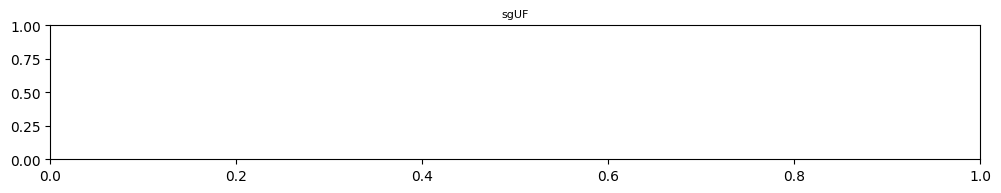

In [46]:
# Diagrama de Tukey (boxplot)
gridsize_boxplot = (4, 1)
fig_boxplot = plt.figure(figsize=(12, 8))

positions = ['sgUF', 'sgPartido', 'vlrLiquido']

for i, position in enumerate(positions):
    boxplot = plt.subplot2grid(gridsize_boxplot, (i, 0))
    boxplot.set_title(position, fontsize=8)
    sns.boxplot(x=position, data=dataset)

plt.tight_layout()
plt.show()

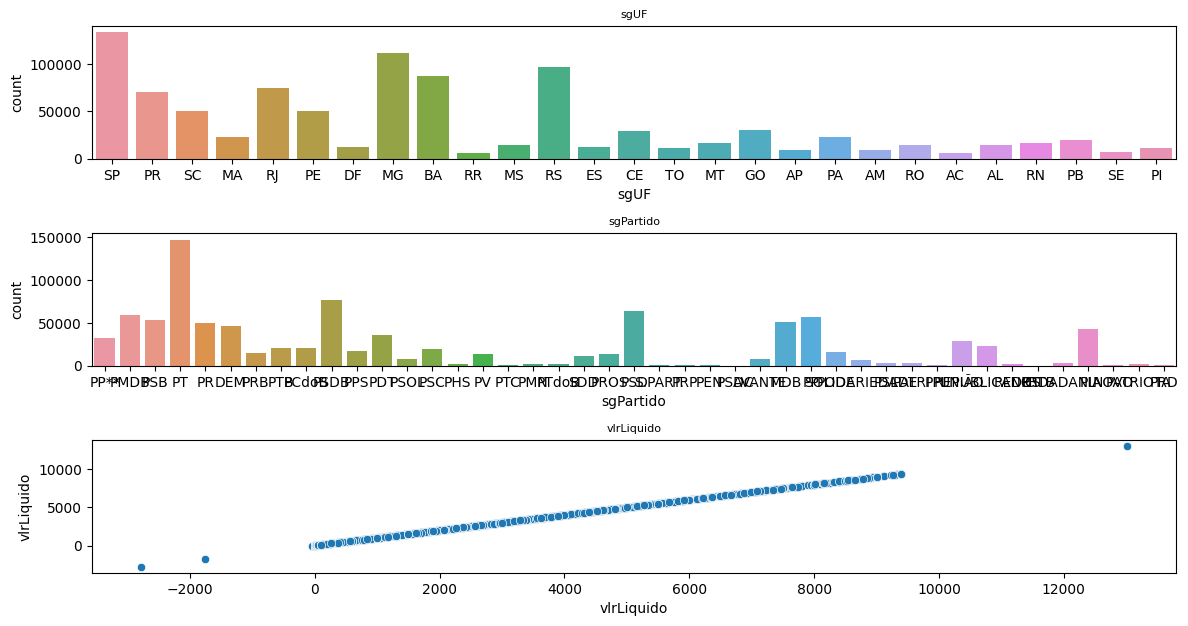

In [47]:
# Gráfico de dispersão
gridsize_scatter = (4, 1)
fig_scatter = plt.figure(figsize=(12, 8))

positions = ['sgUF', 'sgPartido', 'vlrLiquido']

for i, position in enumerate(positions):
    scatterplot = plt.subplot2grid(gridsize_scatter, (i, 0))
    scatterplot.set_title(position, fontsize=8)
    
    if dataset[position].dtype == 'object':
        sns.countplot(x=position, data=dataset, ax=scatterplot)
    else:
        sns.scatterplot(x=position, y='vlrLiquido', data=dataset, ax=scatterplot)

plt.tight_layout()
plt.show()

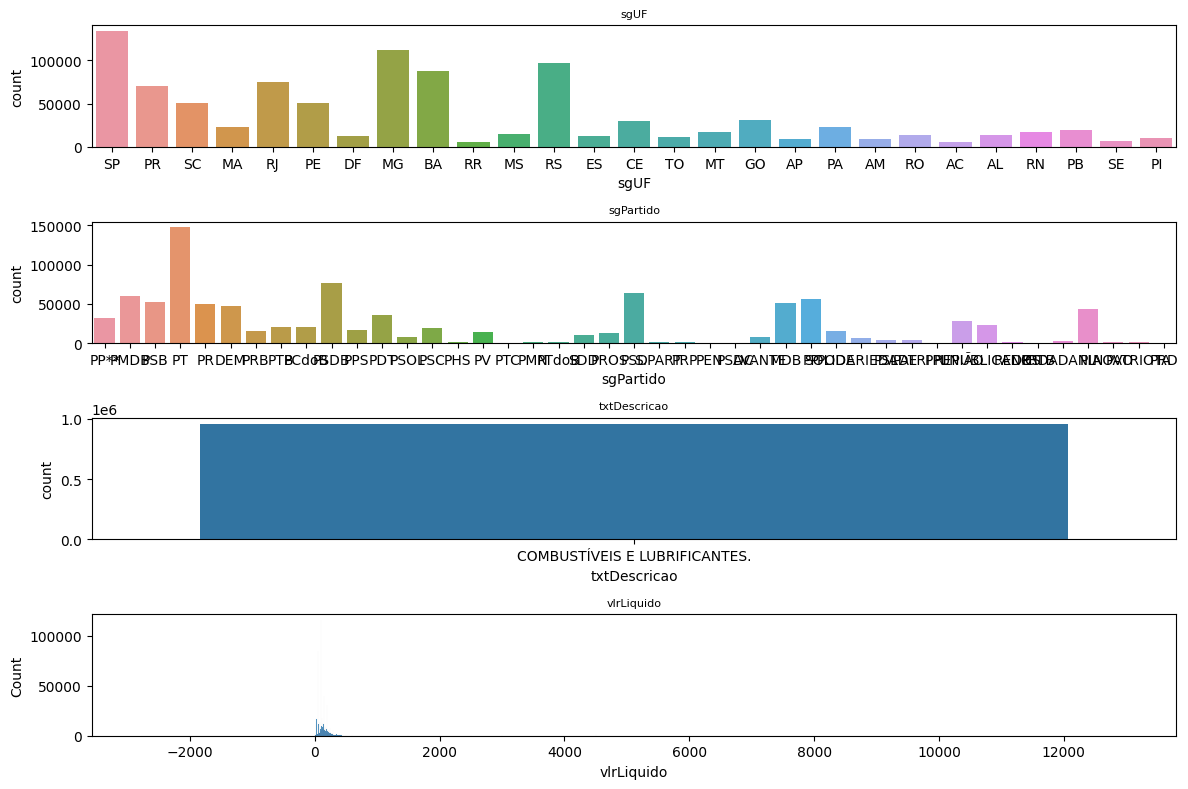

In [48]:
# Histograma
gridsize_barplot = (4, 1)
fig_barplot = plt.figure(figsize=(12, 8))

positions = ['sgUF', 'sgPartido', 'txtDescricao', 'vlrLiquido']

for i, position in enumerate(positions):
    barplot = plt.subplot2grid(gridsize_barplot, (i, 0))
    barplot.set_title(position, fontsize=8)
    
    if dataset[position].dtype == 'object':
        sns.countplot(x=position, data=dataset, ax=barplot)
    else:
        sns.histplot(x=position, data=dataset, ax=barplot)

plt.tight_layout()
plt.show()

In [49]:
# Remover outliers - Winsorization

""" cols = list(dataset.columns)
cols.remove('col')

winsorization_flooring = 0.05
winsorization_capping = 1 - winsorization_flooring

not_selected_data_flooring = dataset[cols] <= dataset[cols].quantile(winsorization_flooring)
not_selected_data_capping = dataset[cols] >= dataset[cols].quantile(winsorization_capping)

not_selected_data_all = (not_selected_data_flooring & not_selected_data_capping)

data_index = dataset[cols][not_selected_data_all].index
dataset[cols].drop(data_index, inplace=True """

" cols = list(dataset.columns)\ncols.remove('col')\n\nwinsorization_flooring = 0.05\nwinsorization_capping = 1 - winsorization_flooring\n\nnot_selected_data_flooring = dataset[cols] <= dataset[cols].quantile(winsorization_flooring)\nnot_selected_data_capping = dataset[cols] >= dataset[cols].quantile(winsorization_capping)\n\nnot_selected_data_all = (not_selected_data_flooring & not_selected_data_capping)\n\ndata_index = dataset[cols][not_selected_data_all].index\ndataset[cols].drop(data_index, inplace=True "

Regressão Linear

In [79]:
dataset = dataset.loc[:,['datEmissao', 'vlrLiquido']]

In [80]:
# A regressão linear do sklearn não conseguiria usar diretamente a data então foi necessário converter
dataset['timestamp_unix'] = (dataset['datEmissao'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
# Agora temos os segundos decorridos desde uma data base

In [81]:
#Parcionando dados
X = dataset[['timestamp_unix']]
y = dataset['vlrLiquido']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)


In [82]:
# Criar modelo
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [83]:
# Predição
predicted_values = model.predict(X_test)

In [84]:
# Análise da regressão
model.score(X_test,y_test)

0.0024315166756544437

<AxesSubplot: xlabel='datEmissao'>

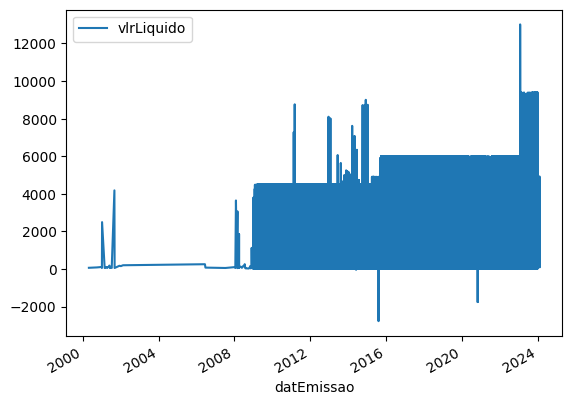

In [89]:
dataset.plot(y='vlrLiquido',x='datEmissao')

In [96]:
despesas_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4666841 entries, 0 to 4666840
Data columns (total 32 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   txNomeParlamentar          object 
 1   cpf                        float64
 2   ideCadastro                float64
 3   nuCarteiraParlamentar      float64
 4   nuLegislatura              int64  
 5   sgUF                       object 
 6   sgPartido                  object 
 7   codLegislatura             int64  
 8   numSubCota                 int64  
 9   txtDescricao               object 
 10  numEspecificacaoSubCota    int64  
 11  txtDescricaoEspecificacao  object 
 12  txtFornecedor              object 
 13  txtCNPJCPF                 object 
 14  txtNumero                  object 
 15  indTipoDocumento           int64  
 16  datEmissao                 object 
 17  vlrDocumento               float64
 18  vlrGlosa                   float64
 19  vlrLiquido                 float64
 20  nu

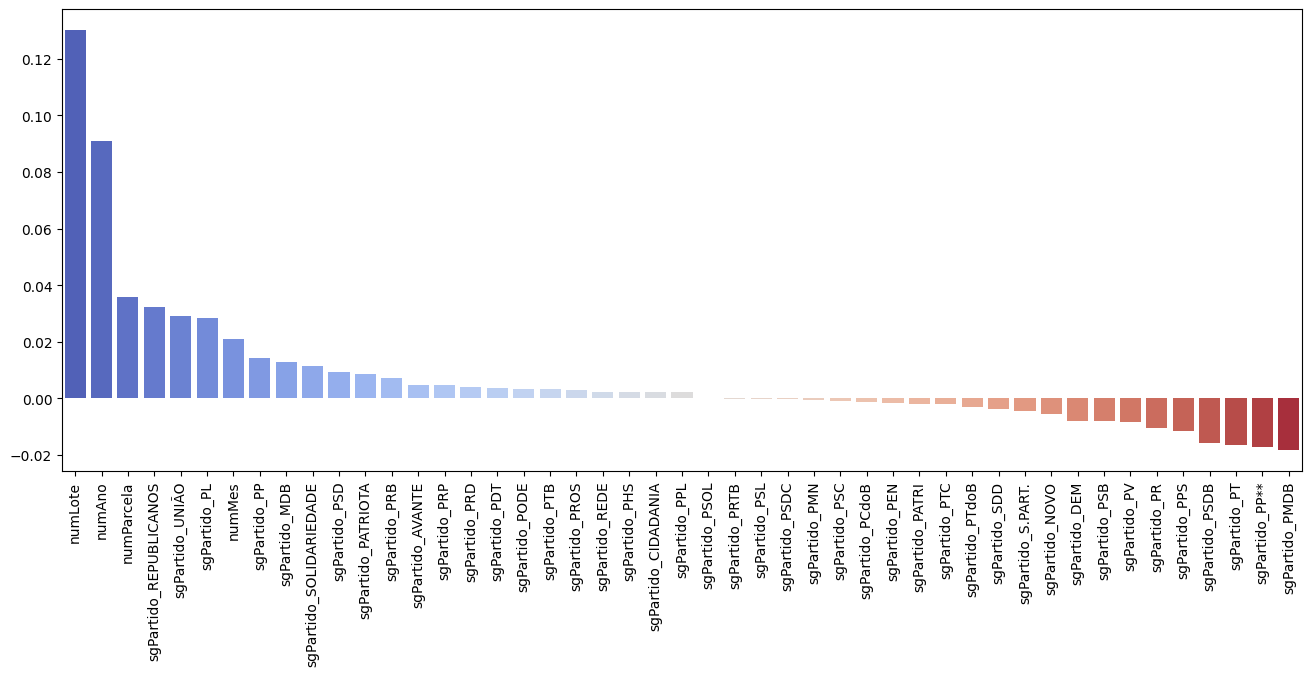

In [100]:
dummies = pd.get_dummies(despesas_completo[['numMes','sgPartido','numAno','numLote','vlrLiquido','numParcela']])
valores = dummies.corr()['vlrLiquido'].sort_values(ascending=False)[1:]

fig, ax = plt.subplots(figsize= (16, 6))
sns.barplot(x=valores.index, y=valores.values, palette='coolwarm')
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('')

plt.show() # Não é possível encontrar relações lineares médias ou fortes ente valor líquido e as outras variáveis